In [1]:
import numpy as np 
import pandas as pd 
import missingno as msno
import matplotlib.pyplot as plt 
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer 
from yellowbrick.classifier import ConfusionMatrix, ClassBalance 
from sklearn.dummy import DummyClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from copy import deepcopy
from sklearn.svm import SVC 
from sklearn.model_selection import (validation_curve,
 learning_curve, GridSearchCV , cross_val_score)
from sklearn.model_selection import KFold, StratifiedKFold , RepeatedStratifiedKFold
from seaborn import boxplot 

#from yellowbrick.classifer import ConfusionMatrix 
import seaborn as sns 
sns.set()


In [2]:
origin_df = pd.read_csv("main.bagciv.data_true.csv")
origin_df.head(5)

,num,name,east,north,power,magnitude,shape,type,sfi,ohmS,lwi,geol,flow
0,1,b1,790496,1175071.0,110,136,W,CP,0.388909,1666.165142,32.023585,VOLCANO-SEDIM. SCHISTS,2.5
1,2,b2,791227,1159566.0,70,142,V,EC,1.340127,1135.551531,21.406531,GRANITES,0.8
2,3,b3,774610,1136762.0,80,87,V,EC,0.446594,767.562500,0.000000,GRANITES,1.0
3,4,b4,776778,1128130.0,60,116,W,NC,0.763676,987.943553,28.709623,GRANITES,1.2
4,5,b5,762550,1144126.0,70,111,W,EC,0.068501,769.095833,2.300000,GEOSYN. GRANITES,1.5


In [3]:
#  drop the features num , east, north, lwi and  and set index to name 
df0=origin_df.drop (["num",
                     "east",
                     "north",
                     "lwi"
                     ], axis =1).set_index("name")
df0.head(5)

,power,magnitude,shape,type,sfi,ohmS,geol,flow
name,,,,,,,,
b1,110,136,W,CP,0.388909,1666.165142,VOLCANO-SEDIM. SCHISTS,2.5
b2,70,142,V,EC,1.340127,1135.551531,GRANITES,0.8
b3,80,87,V,EC,0.446594,767.562500,GRANITES,1.0
b4,60,116,W,NC,0.763676,987.943553,GRANITES,1.2
b5,70,111,W,EC,0.068501,769.095833,GEOSYN. GRANITES,1.5


In [4]:
colums_order =["shape", "type", "geol", "power", "magnitude", "sfi", "ohmS", "flow"]
df_order= df0[colums_order]
df_order.head(5)

,shape,type,geol,power,magnitude,sfi,ohmS,flow
name,,,,,,,,
b1,W,CP,VOLCANO-SEDIM. SCHISTS,110,136,0.388909,1666.165142,2.5
b2,V,EC,GRANITES,70,142,1.340127,1135.551531,0.8
b3,V,EC,GRANITES,80,87,0.446594,767.562500,1.0
b4,W,NC,GRANITES,60,116,0.763676,987.943553,1.2
b5,W,EC,GEOSYN. GRANITES,70,111,0.068501,769.095833,1.5


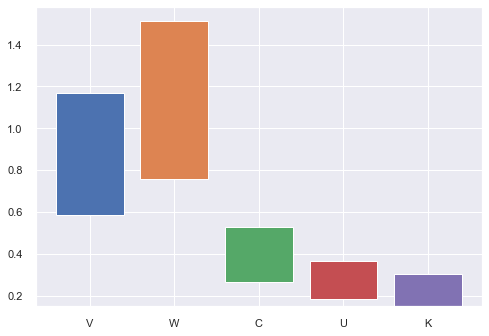

In [5]:
# counter the categorical data 
cat_columns =["shape", "type", "geol"]
dfs = df_order["shape"].value_counts (normalize=True)
dft =df_order["type"].value_counts (normalize=True)
dfg = df_order["geol"].value_counts (normalize=True)

#for df in [dfs, dft, dfg]: 
#    plt.bar (df.index, df)

j =0
for i in  range(len(dfs)): 
    plt.bar (dfs.index[i], dfs.values[i]+ j, bottom = dfs.values[i]+ j)
    j = dfs.values[i] 



In [6]:
#Vectorisation of features shape, type, geol, and y 

def flowMapping (value): 
    if value == 0. : 
        return 0  #FR0
    elif  0 < value <=1:
        return 1 #FR1
    elif 1 < value <=3:
        return 2  # FR2
    else : return 3  #FR3
def binMapping (value): 
    return 0 if value <=1 else 1 

geomap = {"VOLCANO-SEDIM. SCHISTS":1, 
          "GRANITES":3, 
          "GEOSYN. GRANITES":2, 
          "GNEISS-MIGMATITES":4
          }
mapshape ={"W":1, 
          "U":2, 
          "V":3, 
          "H":4, 
          "K":5, 
          "C":6, 
          "M":7}

maptype ={"EC":1, 
          "NC":2, 
          "CP":3, 
          "CB2P":4
}
def geolMapping(value): 
    if value =="VOLCANO-SEDIM. SCHISTS": 
        return "VOLCS."
    elif value =="GRANITES": 
        return "GRAN."
    elif value =="GEOSYN. GRANITES": 
        return "GEOG."
    elif value =="GNEISS-MIGMATITES":
        return "MIGG."
    
# df_order.geol = df_order["geol"].apply (geolMapping)
df_order.flow=df_order["flow"].apply (flowMapping)
df_order.geol = df_order["geol"].map(geomap)
df_order["shape"]=df_order["shape"].map(mapshape)
df_order.type= df_order.type.map(maptype)
df_binary=df_order.copy()
df_binary.flow = df_binary.flow.apply(binMapping)

#df_order.describe()


In [7]:
# separate two datasets , multiclassification and binary 

dfm = df_order.copy() # multiclassification 
dfb = df_binary.copy() # binary classification 



In [8]:
#ax= msno.matrix (dfm.drop(columns="flow"))
#ax.get_figure().savefig("images/mplr_001.png")

In [9]:
#ax= msno.bar (dfm.drop (columns="flow"))
#ax.get_figure().savefig("images/mplr_002.png")

In [10]:
# targets 
y = dfm.flow 
yb = dfb.flow 

X = dfm.drop (columns= "flow") 
Xb = dfb.drop(columns="flow")


In [11]:
# imput the data 
imp_obj = SimpleImputer (strategy ="median")
X_imp = imp_obj.fit_transform (X)
X_imputed =pd.DataFrame (data=X_imp, columns= X.columns)


In [12]:
# Scaled the numerical data 
num_columns =["power", "magnitude", "sfi", "ohmS"]
X_num_imputed= X_imputed[num_columns]
scaler_obj = StandardScaler () 
X_num_scaled = scaler_obj. fit_transform(X_num_imputed)
#X_cat_imputed= X_imputed[cat_columns]
# concat the 
X = np.c_[dfm[cat_columns].values, X_num_scaled]
X= pd.DataFrame (data=X, columns= dfm.drop(columns="flow").columns)
X.head(5)
X_for_validation = X.copy ()

X_for_validation.set_index(y.index)
X.shape

(431, 7)

In [13]:
# One Hot encoded categorical features 

ohe_obj = OneHotEncoder(categories ="auto", drop="first")
c_transf = ColumnTransformer([ 
                              ("ohe",ohe_obj , [0, 1, 2] ), 
                              ("nothing", "passthrough", [3, 4, 5, 6])
                              ])
Xohe=c_transf.fit_transform(X).astype(float)
Xohe.shape



(431, 14)

In [14]:
# RECAP
X = Xohe.copy()
X, y # Dataset for mutiple classification task 
X, yb #Dataset for binary classification task 
#check the fist row of data 
X.shape

(431, 14)

In [15]:
# control class valance 
# fig , ax = plt.subplots(figsize=(6, 6))
# cb_viz= ClassBalance (labels =[0, 1, 2, 3])
# cb_viz.fit(y)
# cb_viz.poof()
#fig.savefig("images/mplr_003.png", dpi =300)


# binaryy 

# fig , ax = plt.subplots(figsize=(6, 6))
# cb_bin= ClassBalance (labels =[0, 1])
# cb_bin.fit(yb)
# cb_bin.poof()
#fig.savefig("images/mplr_004.png", dpi =300)

In [16]:
ycount = y.value_counts(normalize =True)
ybcount =yb.value_counts(normalize =True)
ycount , ybcount 

(2    0.357309
 1    0.354988
 3    0.146172
 0    0.141531
 Name: flow, dtype: float64,
 1    0.50348
 0    0.49652
 Name: flow, dtype: float64)

In [17]:
# stratified sampling 
# multiclassification 

_, _, y_trainno, y_testno=train_test_split (X, y , test_size = 0.2, random_state= 42)
X_train, X_test , y_train, y_test = train_test_split (X, y , test_size = 0.2, random_state= 42, stratify = y)

X_train.shape, X_test.shape , y_train.shape, y_test.shape

((344, 14), (87, 14), (344,), (87,))

In [18]:
# finction to plot class balances 
def plotClassBalances (y, labels, savefig): 
    fig , ax = plt.subplots(figsize=(6, 6))
    cb_bin= ClassBalance (labels =labels)
    cb_bin.fit(y)
    cb_bin.poof()
    fig.savefig(savefig, dpi =300)
    

In [19]:
# plot ytrain, y test balances 
#for ii, yy in enumerate([y_train, y_test]): 
#    plotClassBalances(yy, labels =[0, 1, 2, 3],savefig= f"images/mplr_000z{ii}")
#for ii, yy in enumerate([y_trainno, y_testno]): 
#    plotClassBalances(yy, labels =[0, 1, 2, 3],savefig= f"images/mplr_000no{ii}")
    

In [20]:
#Binarry 
Xbtraino, Xb_testno, yb_trainno, yb_testno=train_test_split (X, yb , test_size = 0.2, random_state= 42)
Xb_train, Xb_test , yb_train, yb_test = train_test_split (X, yb , test_size = 0.2, random_state= 42, stratify = yb)

Xb_train.shape, Xb_test.shape , yb_train.shape, yb_test.shape
# plot ytrain, y test balances 
#for ii, yy in enumerate([yb_train, yb_test]): 
#    plotClassBalances(yy, labels =[0, 1],savefig= f"images/mplr_000b{ii}")
#for ii, yy in enumerate([yb_trainno, yb_testno]): 
#    plotClassBalances(yy, labels =[0, 1],savefig= f"images/mplr_000bno{ii}")
    

((344, 14), (87, 14), (344,), (87,))

In [21]:
#RECAP
#multiclassification  Database 
X_train , y_train , X_test, y_test 
# binary classifier 
Xb_train, yb_train, Xb_test, yb_test 
yb.shape

(431,)

In [22]:
# TQUick test with dumy classifier  Baseline Model 
bm = DummyClassifier(random_state=42)
bm.fit(X_train, y_train)
bm.score (X_test, y_test) 




0.3563218390804598

In [23]:
# dumy classifier with Binary 
bmb = DummyClassifier(random_state=42)
bmb.fit(Xb_train, yb_train)
bmb.score (Xb_test, yb_test) 

0.5057471264367817

In [24]:
#Draw the box plots of class labels with no stratified and classified folds 
from sklearn.model_selection import KFold, StratifiedKFold 
from seaborn import boxplot 
cv=4


In [25]:
print(X_for_validation.shape)
Xtrainfv , Xtestfv , ytrainfv , ytestfv = train_test_split (
    X_for_validation.reset_index(drop =True), y.reset_index (drop =True), test_size =0.2, random_state = 42)

kf =KFold (n_splits=cv, random_state= 42, shuffle=True)   

(431, 7)


In [26]:

# print(Xtrainfv.set_index (ytrainfv.index))
# print( ytrainfv.index )
num_val_samples = len(Xtrainfv)//cv 
train_data = Xtrainfv.copy().values 
train_targets = ytrainfv.copy().values 

def boxPlotFold (cv , trainset , traintarget, samples, savefig, plottrain=True, viz =True ):
    for i in range (cv): 
        val_data = trainset [i * samples: (i+1) * samples]
        val_targets = traintarget [i * samples: (i+1) * samples]
        partial_train_data = np.concatenate(
            [trainset[:i * samples ], 
            trainset[(i+1) * samples:]], 
            axis =0
        )
        
        if viz:
            fig, ax = plt.subplots (figsize =(8, 6))
            
            if plottrain:
                boxplot( data =val_data )
            if not plottrain:
                boxplot( data =val_targets )
            
            if savefig is not None: 
                fig.savefig(savefig +f"{i+1}.png", dpi =300)

#     Xtrain, Xtest =Xtrainfv[train_index] , Xtrainfv[test_index]
#     ytrain, ytest = ytrainfv[train_index] , ytrainfv[test_index]
    
    # data = pd.DataFrame (
    #     data =Xtrain,  columns=[f"num{i}" for i in range (Xtrain.shape[1])]).set_index (
    #         ytrain.index )
    # data =pd.merge(data, ytrain, on ="name", how ="outer")
    # print(data.head(5))
    #print(pd.merge ([data , ytrain.reset_index (drop=True )], how ="outer").head(5))
    #fig, ax = plt.subplots (figsize =(8, 6))
    #sns.boxplot( data =Xtrain )


In [27]:
#STRATIFIED Fold 
Xtrainfv , Xtestfv , ybtrainfv , ybtestfv = train_test_split (
    X_for_validation.reset_index(drop =True), yb.reset_index (drop =True), test_size =0.2, random_state = 42, stratify = y)

num_val_samples = len(Xtrainfv)//cv 
train_data = Xtrainfv.copy().values 
train_targets = ybtrainfv.copy().values 

boxPlotFold (cv=4 , trainset=train_data ,
            traintarget = train_targets, 
            samples= num_val_samples, 
            savefig="images/StratifiedFromY",
            plottrain=False, 
            viz=False)
boxplot

In [28]:
# stratified kfold index 
# mutilcalss
cv_index= StratifiedKFold(n_splits =4)
cv2_index = KFold(n_splits=4, random_state =42 , shuffle =True)

### Multiclassification

In [29]:

cv = list(cv_index.split(X_train, y_train))
cv2 = list(cv2_index.split(X_train, y_train))

# for k, (train_index , test_index) in enumerate (cv2 ): 
    # fig, ax = plt.subplots (figsize =(8, 6))
    # sns.boxplot (data = X_train[train_index])
    # fig.savefig(f"images/wfoldnotrat{k+1}.png", dpi =300)



In [30]:
# create a SVM0 


(array([0.36046512, 0.36046512, 0.36046512, 0.62790698, 0.73837209,
        0.76744186]),
 array([0.48809524, 0.48809524, 0.48809524, 0.48809524, 0.72186147,
        0.72077922]))

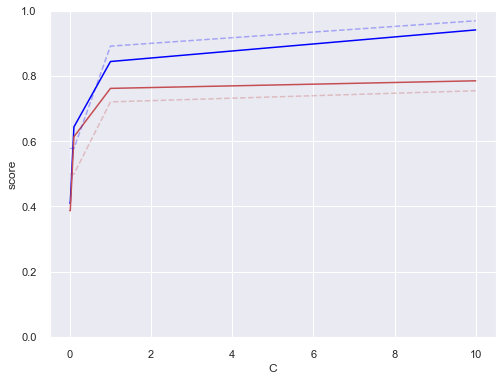

In [43]:

svm0 = SVC()
k_range_paramC = np.power(10 , np.arange(-4, 1.5, dtype =float))
k1 = len(X_train)//4
Xsample = X_train [:k1, :]
ysample = y_train[:k1]


train_score1 , val_score1 = validation_curve(svm0, Xsample, ysample, 
                                         param_name ="C", param_range=k_range_paramC,
                                         cv=4)
train_score , val_score = validation_curve(svm0, X_train, y_train, 
                                         param_name ="C", param_range=k_range_paramC,
                                         cv=4)
fig, ax = plt.subplots (figsize =(8, 6))
ax.plot(k_range_paramC, np.mean(train_score, 1), color ="blue", label ="train score")
ax.plot(k_range_paramC, np.mean(val_score, 1), color ="r", label ="validation score")
ax.plot(k_range_paramC, np.mean(train_score1, 1), color ="blue", label ="train score Fold1", alpha =0.3, linestyle ="--")
ax.plot(k_range_paramC, np.mean(val_score1, 1), color ="r", label ="validation score Fold 1", alpha =0.3, linestyle ="--")
#ax.legend(loc="best")
ax.set_ylim(0, 1)
ax.set_xlabel("C")
ax.set_ylabel("score")


# fig.savefig ("images/valscoreFor1foldand4Fold.png", dpi =300)

np.median(val_score, 1), np.median(val_score1, 1)

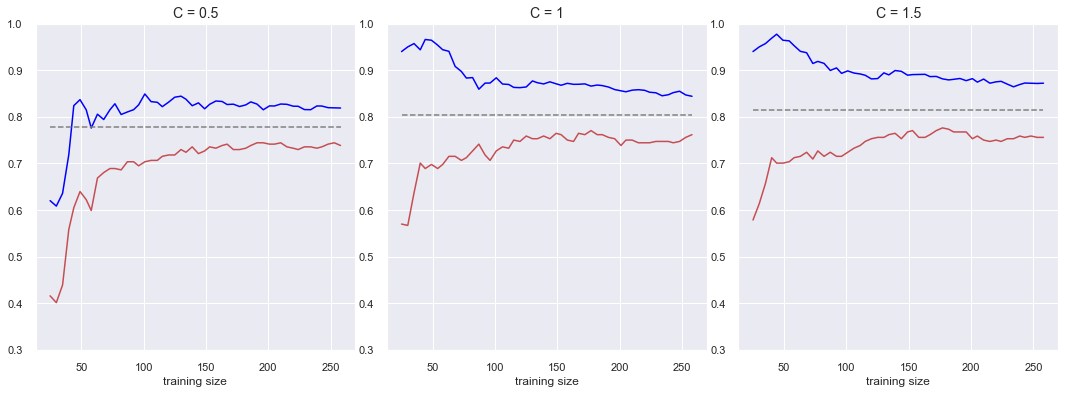

In [46]:


fig, ax = plt.subplots(1, 3, figsize =(16, 6))
fig.subplots_adjust(left=0.0625, right = 0.95, wspace = 0.1)
paramC_test =[0.5, 1, 1.5]
for k, paramc in enumerate(paramC_test): 
    N, train_lc , val_lc = learning_curve(SVC(C=paramc), X_train, y_train, 
                                            train_sizes = np.linspace(0.1, 1, 50),
                                            cv=cv)
    ax[k].plot(N, np.mean(train_lc, 1), color ="blue", label ="train score")
    ax[k].plot(N, np.mean(val_lc, 1), color ="r", label ="validation score")
    ax[k].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color="gray", linestyle ="--")
    ax[k].set_ylim(0.3, 1)
    #ax[k].set_xlim (N[0], N[1])
    ax[k].set_xlabel("training size")
    #ax[k].set_ylabel("score")
    ax[k].set_title('C = {0}'.format(paramc), size=14)
    #ax[k].legend(loc="best")
    
    fig.savefig (f"learninfcurveSVM02_Ceq{paramc}.png", dpi =300)
    
    

    

In [33]:
# Hyperparameters fine-tuning 
# kws_bases = {
#     "C": np.power(2 , np.arange(-5, 9,2,  dtype =float)), 
#     "gamma":np.power(2, np.arange(-7, 5,2,  dtype =float)), 
#     "tol":np.power(10 , np.arange(-3, 4, 1,  dtype =float)), 
#     "coef0":np.arange(0, 8),
#     "degree":np.arange(1, 5),
# }

kws_bases = {
    "C": np.power(2 , np.arange(-7, 11,2,  dtype =float)), 
    "gamma":np.power(2, np.arange(-11, 9,2,  dtype =float)), 
    "tol":np.power(10 , np.arange(-3, 4, 1,  dtype =float)), 
    "coef0":np.arange(0, 8),
    "degree":np.arange(1, 8),
}

def generateParams (kernels , params_kws=None): 
    args =[]
    for kernel in kernels : 
        params_kws['kernel'] = [kernel]
        paramgk= deepcopy (params_kws.copy())
        args.append(paramgk)
        del params_kws['kernel']
    
    return args 
param_grids= generateParams(kernels =['poly', 'linear', 'sigmoid', 'rbf'],
params_kws=kws_bases )


In [34]:
def gridSearchSVM (clf, X, y, *,  scoring ='accuracy', param_grid =None,
                    cv =None, nestedcv =True): 

    gsobj = GridSearchCV (estimator =clf, 
                   param_grid=param_grid, 
                   scoring =scoring , 
                   cv =cv  , refit=True,
                    n_jobs=-1)
   
    if nestedcv: 
        scores= cross_val_score(gsobj, X, y, scoring =scoring , cv =cv )
        print(f'{param_grid ["kernel"][0]}: CV accuracy: %3.f +/- %3.f' %(np.mean(scores), np.std(scores)) )

    gsobj = gsobj.fit(X, y)
    return gsobj, scores if nestedcv else None

                 

In [35]:
# run all grid searches

# gridObjs , gridScores ={}, {}
# for param_grid , kernel in zip(param_grids, 
# ['poly', 'linear', 'sigmoid', 'rbf']): 
#     gs , scores= gridSearchSVM (SVC(), X=X_train, y=y_train, 
#      param_grid= param_grid ,
#      cv =cv )
#     print(f" {kernel.capitalize()} - best score:", gs.best_score_ ) 
#     print(f"{kernel.capitalize()} - best params:", gs.best_params_)
#     gridObjs[kernel] = gs 
#     gridScores [kernel]=scores 


In [36]:
try :
    import joblib 
except: pass 

import pickle 

# filename = '__svmmodels'
# data = (gridObjs, gridScores)
# try : 
#         joblib.dump(data, f'{filename}.pkl')
# except : 
#     # Now try to pickle data Serializing data 
#     filename +='.pkl'
#     with open(filename, 'wb') as wfile: 
#         pickle.dump( data, wfile)
gridObjs, gridScores = joblib.load ('__svmmodels.pkl')

In [37]:
len(gridObjs['sigmoid'].cv_results_['params'])

35280

In [38]:
CV0=4
SVMLinear = gridObjs['linear']
SVMpoly = gridObjs['poly']
SVMrbf = gridObjs['rbf']
SVMsigmoid = gridObjs['sigmoid']

cvres_poly = SVMpoly.cv_results_
cvres_linear= SVMLinear.cv_results_
cvres_rbf= SVMrbf.cv_results_
cvres_sigmoid= SVMsigmoid .cv_results_


SVMs = [SVMLinear, SVMpoly , SVMrbf, SVMsigmoid ] 
SVMsCV_res =[cvres_linear, cvres_poly, cvres_rbf, cvres_sigmoid]

kernels =['Linear', 'Polynomial', 'RBF', 'Sigmoid']



In [39]:

def getGlobalScores(cvres): 
    """ Take the global mean score  and std  test score"""
    return cvres['mean_test_score'].mean() , cvres['std_test_score'].mean()

def getBestForEachSplit(cvres, split=1): 
    if split ==0: split =1 
    split_score = cvres[f'split{split-1}_test_score'] # get the split score 
    # take the max score of the split 
    max_sc = split_score.max() 
    ix_max = split_score.argmax()
    mean_score= split_score.mean()
    # get parm and mean score 
    bests ={'param': cvres['params'][ix_max], 
        'accuracy_score':cvres['mean_test_score'][ix_max], 
        'std_score':cvres['std_test_score'][ix_max],
        f"CV{split}_score": max_sc , 
        f"CV{split}_mean_score": mean_score,
        }

    return bests 




In [40]:
def vizSVModelDetailsMax(cvres ):
    for k in range(CV0):
        print(f'split =CV{k+1}:')
        b= getBestForEachSplit(cvres, split =k)
        print( b)

    globalmeansc , globalstdsc= getGlobalScores(cvres)
    print("Global split scores:")
    print('mean=', globalmeansc , 'std=',globalstdsc)

for kern,  mdetail, model in zip(kernels, SVMsCV_res, SVMs): 
    print(kern, ':')
    vizSVModelDetailsMax(cvres=mdetail)
    print('BestParams: ', model.best_params_)
    print("Best scores:", model.best_score_)
    print()
    

Linear :
split =CV1:
{'param': {'C': 0.125, 'coef0': 0, 'degree': 1, 'gamma': 0.00048828125, 'kernel': 'linear', 'tol': 1.0}, 'accuracy_score': 0.7674418604651163, 'std_score': 0.03583961629633128, 'CV1_score': 0.8255813953488372, 'CV1_mean_score': 0.49095607235142125}
split =CV2:
{'param': {'C': 0.125, 'coef0': 0, 'degree': 1, 'gamma': 0.00048828125, 'kernel': 'linear', 'tol': 1.0}, 'accuracy_score': 0.7674418604651163, 'std_score': 0.03583961629633128, 'CV1_score': 0.8255813953488372, 'CV1_mean_score': 0.49095607235142125}
split =CV3:
{'param': {'C': 32.0, 'coef0': 0, 'degree': 1, 'gamma': 0.00048828125, 'kernel': 'linear', 'tol': 0.001}, 'accuracy_score': 0.7877906976744187, 'std_score': 0.0437980208526726, 'CV2_score': 0.813953488372093, 'CV2_mean_score': 0.47895902547065344}
split =CV4:
{'param': {'C': 32.0, 'coef0': 0, 'degree': 1, 'gamma': 0.00048828125, 'kernel': 'linear', 'tol': 0.001}, 'accuracy_score': 0.7877906976744187, 'std_score': 0.0437980208526726, 'CV3_score': 0.83720

In [41]:
SVMs = [SVMLinear, SVMpoly , SVMrbf, SVMsigmoid ] 

paramC_test = [ model.best_params_['C'] for model in SVMs ]
paramC_test
hparamLinear =['kernel', 'C', 'tol', ]
hparamPoly =['kernel', 'C', 'tol', 'gamma', 'degree', 'coef0']
hparamrbf =['kernel', 'C', 'tol', 'gamma']
hparamsigmoid =['kernel', 'C', 'tol', 'gamma',  'coef0']
StrParamsList = [hparamLinear , hparamPoly, hparamrbf, hparamsigmoid  ]
temp0=list()
makeParamsStrings =list()
for pstrl, model in zip(StrParamsList  , SVMs ): 
    for k in pstrl: 
        for key , values in model.best_params_.items(): 
            if key ==k :
                try :
                    temp0.append(f'{k} = {round(values, 4)}') 
                except: 
                    temp0.append(f'{k} = {values}') 
    makeParamsStrings .append(', '.join(temp0) )
    temp0=[]
    #fig.savefig (f"images/learninfcurveSVM0_Ceq{paramc}.png", dpi =300)
makeParamsStrings 

['kernel = linear, C = 8.0, tol = 1.0',
 'kernel = poly, C = 0.5, tol = 0.1, gamma = 0.125, degree = 4, coef0 = 2',
 'kernel = rbf, C = 512.0, tol = 1.0, gamma = 0.0078',
 'kernel = sigmoid, C = 128.0, tol = 1.0, gamma = 0.002, coef0 = 0']

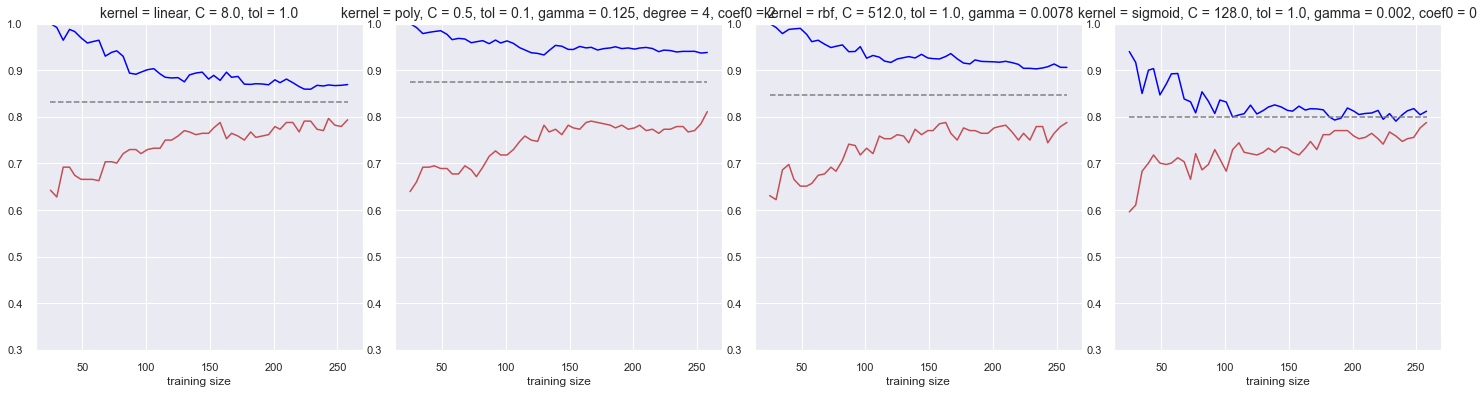

In [47]:
fig, ax = plt.subplots(1, 4, figsize =(22, 6))
fig.subplots_adjust(left=0.0625, right = 0.95, wspace = 0.1)
paramC_test =[0.5, 1, 1.5]

for k, (model, parmL) in enumerate(zip(SVMs, makeParamsStrings)): 
    N, train_lc , val_lc = learning_curve(SVC(**model.best_params_), X_train, y_train, 
                                            train_sizes = np.linspace(0.1, 1, 50),
                                            cv=cv)
    ax[k].plot(N, np.mean(train_lc, 1), color ="blue", label ="train score")
    ax[k].plot(N, np.mean(val_lc, 1), color ="r", label ="validation score")
    ax[k].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color="gray", linestyle ="--")
    ax[k].set_ylim(0.3, 1)
    #ax[k].set_xlim (N[0], N[1])
    ax[k].set_xlabel("training size")
    #ax[k].set_ylabel("score")
    ax[k].set_title(parmL, size=14)
    #ax[k].legend(loc="lower left")

## Error evaluation 

In [48]:
from sklearn.metrics import (confusion_matrix, accuracy_score, f1_score, 
                            roc_auc_score, precision_score, recall_score) 
from yellowbrick.classifier import (ROCAUC, PrecisionRecallCurve , ClassPredictionError ,
                         ConfusionMatrix , ClassificationReport)


In [71]:
mappingc ={0:'FR0', 1:'FR1', 2:"FR2", 3:"FR3"}
classes =['FR0', 'FR1', "FR2", "FR3"]
# quick metrics 
def accuracyScore (ytrue, ypred): 
    return accuracy_score (ytrue, ypred)

# Useful functions 
def predictTestSet (model, X): 
    ypred = model.predict(X)
    return ypred 

def visualizeCfxFromSklearn (ytrue, ypred, plot =True, ax=None ): 
    mat= confusion_matrix (ytrue, ypred)
    if plot: 
        sns.heatmap (mat.T, square =True, annot =True,  fmt='d', cbar=False, ax=ax)
        #xticklabels= list(np.unique(ytrue.values)), yticklabels= list(np.unique(ytrue.values)))
        ax.set_xlabel('true labels')
        #ax.set_ylabel ('predicted label')
    return mat 
    
def visualizeCfxFromYellowbrick (model, XTest, yTest, savefig =None, 
            figsize =(6, 6), labels =classes , label_encoder = mappingc ): 
    fig, ax = plt.subplots(figsize = figsize )
    cm_viz= ConfusionMatrix (model, 
                            classes=labels, 
                        label_encoder = label_encoder, 
                         )
    cm_viz.score(XTest, yTest)
    cm_viz.poof()

    if savefig is not None: 
        fig.savefig(savefig, dpi =300)
    return cm_viz 

def classPredictorError(model, XTest, yTest, savefig =None, 
            figsize =(6, 6), labels =classes ): 
    cpe_viz = ClassPredictionError(model, classes =labels)
    cpe_viz .score(XTest, yTest)
    cpe_viz .poof()
    if savefig is not None: 
        fig.savefig(savefig, dpi =300)
    return ax


Linear : accuracy -score =  0.7816091954022989
Polynomial : accuracy -score =  0.8160919540229885
RBF : accuracy -score =  0.7931034482758621
Sigmoid : accuracy -score =  0.7701149425287356


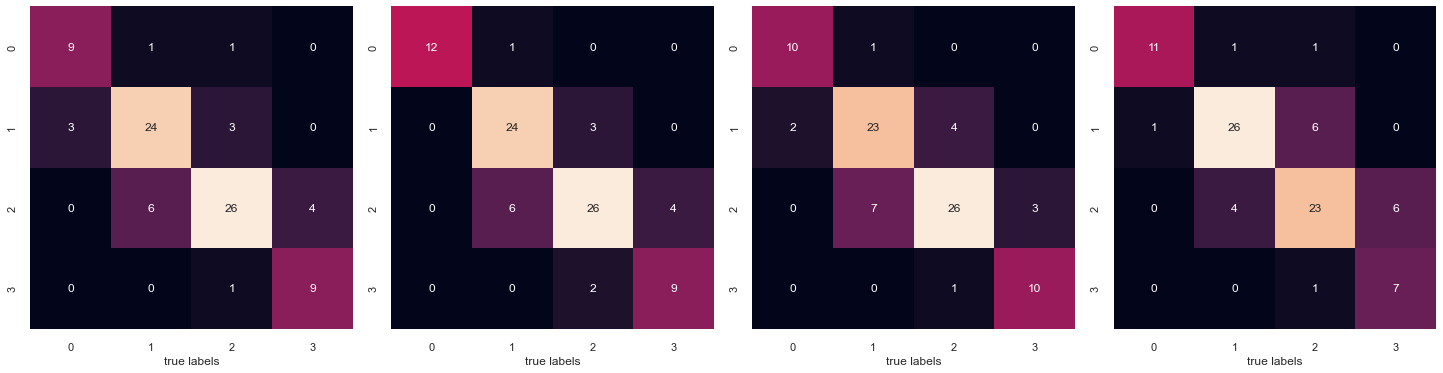

In [72]:
#SVMs = [SVMLinear, SVMpoly , SVMrbf, SVMsigmoid ] 
#kernels =['Linear', 'Polynomial', 'RBF', 'Sigmoid']
fig, ax = plt.subplots(1, 4, figsize =(22, 6))
fig.subplots_adjust(left=0.0625, right = 0.95, wspace = 0.12)

def multipleEvaluationKplus(X,y ,  sklfx =True, yelcfx=False, axis =None):
    if sklfx : 
        yelcfx=False 
    elif yelcfx: sklfx =False 
    for kk, (svm , kern) in enumerate(zip(SVMs, kernels )): 
        ypred = predictTestSet (svm, X)
        acc_scores = accuracy_score(y, ypred)
        print(f"{kern} : accuracy -score = ", acc_scores)
        if sklfx : 
            visualizeCfxFromSklearn(y, ypred, ax = axis[kk] )
        if yelcfx:
            visualizeCfxFromYellowbrick(svm, X, y)
        
multipleEvaluationKplus(X_test, y_test, axis =ax )

C:\anaconda3\envs\svmenv\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


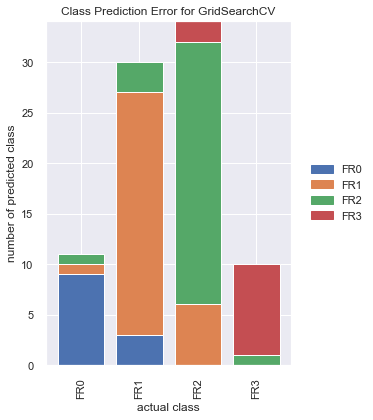

C:\anaconda3\envs\svmenv\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


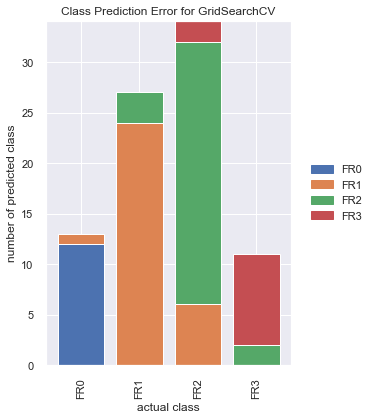

C:\anaconda3\envs\svmenv\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


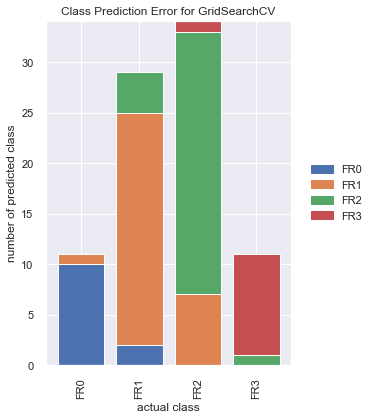

C:\anaconda3\envs\svmenv\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


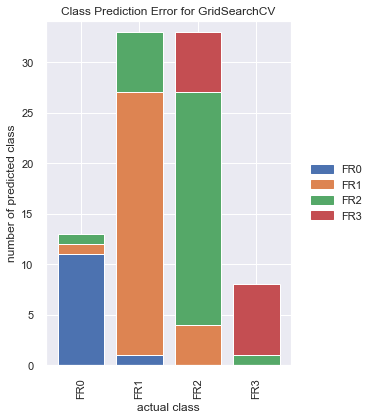

In [68]:

for kk, (svm , kern) in enumerate(zip(SVMs, kernels )): 
    ax[kk]= classPredictorError(svm, X_test, y_test)